# Optuna tutorial for begginers: hyperparameter optimization framework

When I try building a model (XGBoost, LightGBM, CatBoost, Neural Network etc...), I always face an issue of how to tune these hyperparameters?<br>
Some people may be trying to set parameters manually to see if the score improves or not.

**In this tutorial, I will introduce [optuna](https://optuna.org/), *Define-by-Run Hyperparameter Optimization Framework* for automated hyperparameter tuning.**

**<p style="color:red">UPDATE: added [6. Visualize study history to analayze the hyperparams-performance relationship](#id6) section, please check!!!</p>**

In [1]:
from IPython.display import HTML

HTML('<iframe width="800" height="400" src="https://www.youtube.com/embed/-UeC4MR3PHM?start=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Table of Contents:

Below code forked and a bit modified from [ASHRAE: Training LGBM by meter type](https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type) kernel (taken from version 25) until data preprocessing.<br>
Please jump to **[1. Define objective function](#id1)** to start learning optuna usage!

**[ASHRAE - Great Energy Predictor III](#title)** <br>
**[Data Preprocessing](#id0)** <br>
**[1. Define "objective" function](#id1)** <br>
**[2. Use "trial" module to define hyperparameters dynamically!](#id2)** <br>
**[3. Make "study" and let optimize!](#id3)** <br>
**[4. [Advanced] Pruning unpromising trials for more faster search](#id4)** <br>
**[5. Check study history to get best hyperparameters](#id5)** <br>
**[6. Visualize study history to analayze the hyperparams-performance relationship](#id6)** <br>
**[More to go](#id10)** <br>

In [2]:
"""
Some visualization methods used in this tutorial is supported in optuna master branch (from v0.18 in the future)
However this kaggle kernel pre-installs version 0.16.0
"""
#!pip install -U optuna
!pip install git+git://github.com/pfnet/optuna.git@50759344231194046fc8f7968ce906428f36bee1

  Cloning git://github.com/pfnet/optuna.git (to revision 50759344231194046fc8f7968ce906428f36bee1) to /tmp/pip-req-build-p64o1m7g
  Running command git clone -q git://github.com/pfnet/optuna.git /tmp/pip-req-build-p64o1m7g
  Running command git checkout -q 50759344231194046fc8f7968ce906428f36bee1
  Created wheel for optuna: filename=optuna-0.17.1-cp36-none-any.whl size=161398 sha256=185af3399ca5c5f449280ace1dc19d932557c8f23f9700c3dfb8aa510448c2e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-3p4hnxex/wheels/ff/b1/dc/6a4fa4817cebf3242daa9fc9634a04b8c29688d40e8ac56a88
Successfully built optuna
  Found existing installation: optuna 0.16.0
    Uninstalling optuna-0.16.0:
      Successfully uninstalled optuna-0.16.0


<a id="title"></a>
# ASHRAE - Great Energy Predictor III

Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

Electricity and water consumption may have different behavior!
So I tried to separately train & predict the model.

I moved previous [ASHRAE: Simple LGBM submission](https://www.kaggle.com/corochann/ashrae-simple-lgbm-submission) kernel.

In [3]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


In [4]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
!ls ../input

ashrae-energy-prediction  ashrae-feather-format-for-fast-loading


## Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [6]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



CPU times: user 2.2 s, sys: 964 ms, total: 3.17 s
Wall time: 6.15 s


/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



In [7]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [8]:
np.sum(train_df['meter_reading_log1p'].values < 0)

0

In [9]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

In [10]:
plot_date_usage(train_df, meter=0, building_id=0)

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [11]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [12]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

<a id="id0"></a>
# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.


[UPDATE]
 - Processing of 'weekend'
 - Take building stats by building_id **and meter type**
 - Align timestamp in weather data, by@nz0722 https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type

In [13]:
debug = False

## Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags

#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [14]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
#     df["day"] = df["timestamp"].dt.day
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["weekend"] = df["dayofweek"] >= 5

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [15]:
preprocess(train_df)

In [16]:
# take stats by ONLY building_id. meter type is merged in this script...

# df_group = train_df.groupby('building_id')['meter_reading_log1p']
# building_mean = df_group.mean().astype(np.float16)
# building_median = df_group.median().astype(np.float16)
# building_min = df_group.min().astype(np.float16)
# building_max = df_group.max().astype(np.float16)
# building_std = df_group.std().astype(np.float16)

# train_df['building_mean'] = train_df['building_id'].map(building_mean)
# train_df['building_median'] = train_df['building_id'].map(building_median)
# train_df['building_min'] = train_df['building_id'].map(building_min)
# train_df['building_max'] = train_df['building_id'].map(building_max)
# train_df['building_std'] = train_df['building_id'].map(building_std)

In [17]:
df_group = train_df.groupby(['building_id', 'meter'])['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

In [18]:
building_stats_df = pd.concat([building_mean, building_median, building_min, building_max, building_std], axis=1,
                              keys=['building_mean', 'building_median', 'building_min', 'building_max', 'building_std']).reset_index()
train_df = pd.merge(train_df, building_stats_df, on=['building_id', 'meter'], how='left', copy=False)

In [19]:
train_df.head()

,building_id,meter,timestamp,meter_reading,date,meter_reading_log1p,hour,month,dayofweek,weekend,building_mean,building_median,building_min,building_max,building_std
0,105,0,2016-01-01,23.303600,2016-01-01,3.190624,0,1,4,False,4.316406,4.332031,3.191406,5.164062,0.318115
1,106,0,2016-01-01,0.374600,2016-01-01,0.318163,0,1,4,False,0.751953,0.559082,0.000000,2.890625,0.478516
2,106,3,2016-01-01,0.000000,2016-01-01,0.000000,0,1,4,False,1.023438,0.000000,0.000000,3.712891,1.268555
3,107,0,2016-01-01,175.184006,2016-01-01,5.171529,0,1,4,False,4.570312,5.781250,0.039703,6.382812,2.009766
4,108,0,2016-01-01,91.265297,2016-01-01,4.524668,0,1,4,False,5.457031,5.449219,4.417969,6.113281,0.216187


## Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [20]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [21]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [22]:
weather_test_df = pd.read_feather(root/'weather_test.feather')
weather = pd.concat([weather_train_df, weather_test_df],ignore_index=True)
del weather_test_df
weather_key = ['site_id', 'timestamp']

In [23]:
# https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type

temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

del weather
del temp_skeleton
gc.collect()

30557

In [24]:
weather_train_df = timestamp_align(weather_train_df)
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [25]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [26]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [27]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.000000,6.0,20.0,-1.0,1019.700012,0.0,0.0,5,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.400000,4.0,21.1,-1.0,1020.200012,70.0,1.5,5,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,5,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,5,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,5,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [28]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'offset', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_spe

In [29]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [30]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1326.46 MB
Memory usage after optimization is: 795.89 MB
Decreased by 40.0%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.1%
Memory usage of dataframe is 20.93 MB
Memory usage after optimization is: 18.13 MB
Decreased by 13.4%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,5,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000,5,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,5,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,5,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,5,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 13:00:00,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219,6,...,1000.0,6.726562,211.000000,310.0,0.0,72.00000,5.046875,11.296875,0.0,2.525391
139769,15,2016-12-31 14:00:00,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,6,...,1000.0,6.578125,209.875000,310.0,0.0,71.87500,5.125000,11.296875,0.0,2.519531
139770,15,2016-12-31 15:00:00,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,6,...,1000.0,6.421875,212.375000,310.0,0.0,67.43750,5.195312,11.296875,0.0,2.443359
139771,15,2016-12-31 16:00:00,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,6,...,1000.0,6.246094,211.375000,310.0,0.0,67.56250,5.226562,11.296875,0.0,2.423828


In [31]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


## Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [32]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
weather_cols = [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', 'dayofweek', # 'month'
    'building_median'] + weather_cols

In [33]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

<a id="id1"></a>
# 1. Define "objective" function

To start hyperparameter tuning, we need an objective function to optimize the score.<br>
**`objective` method needs to receive `trial` object as args, and return "score" to be optimized.**<br>
(What is trial module? it is explained in next section) 

```
def objective(trial, ...):
    # calculate score...
    return score
```

Below example, I train LightGBM model (only for electricity meter), get best validation score, and return this validation score as the final score.

**The `objective` function is called many times** by `optuna` framework to try different hyperparameters, to search best hyperparameters.

In [34]:
import optuna
from optuna import Trial

optuna.__version__

'0.17.1'

In [35]:
debug = False

train_df_original = train_df
# Only use 10000 data,,, for fast computation for debugging.
train_df = train_df.sample(10000)

In [36]:
def objective(trial: Trial, fast_check=True, target_meter=0, return_info=False):
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = create_X_y(train_df, x=target_meter)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('target_meter', target_meter, X_train.shape)

    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=category_cols,
                                            num_rounds=1000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

Here I passed `trial` module to `fit_lgbm` function, which is the core training code and defines hyperparameters.<br>
Let's see inside of `fit_lgbm` module next.

<a id="id2"></a>
# 2. Use "trial" module to define hyperparameters dynamically!

trial module can be used to get hyperparameters.
As shown in below figure, we just need to get hyperparameters from `trial` module where we want to use hyper parameters!

<img src="https://optuna.org/assets/img/define-by-run.png"></img>
from [https://optuna.org/](https://optuna.org/)

This scheme is called "Define-by-Run" which makes user to intuitively write code to get hyperparameters, instead of defining whole search space in advance.

You can call these methods to get hyperparametes (ref: [Defining Parameter Spaces](https://optuna.readthedocs.io/en/latest/tutorial/configurations.html#defining-parameter-spaces)):

    # Categorical parameter
    optimizer = trial.suggest_categorical('optimizer', ['MomentumSGD', 'Adam'])

    # Int parameter
    num_layers = trial.suggest_int('num_layers', 1, 3)

    # Uniform parameter
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 1.0)

    # Loguniform parameter
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Discrete-uniform parameter
    drop_path_rate = trial.suggest_discrete_uniform('drop_path_rate', 0.0, 1.0, 0.1)


In [37]:
# Referred https://github.com/pfnet/optuna/blob/master/examples/lightgbm_simple.py

def fit_lgbm(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'regression',
#               'max_depth': -1,
        'learning_rate': 0.1,
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

<a id="id3"></a>
# 3. Make "study" and let optimize!

After you define `objective` function and write a code to use hyperparamers by `trial` module, we are ready to go!

Just 2 lines of code do the all troublesome hyperparameter tuning for you. That's all!!

In [38]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.395202	valid_1's l2: 0.471115
[40]	training's l2: 0.27295	valid_1's l2: 0.435487
[60]	training's l2: 0.223433	valid_1's l2: 0.429822
Early stopping, best iteration is:
[55]	training's l2: 0.231495	valid_1's l2: 0.423197
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2314952489319087}, 'valid_1': {'l2': 0.42319692111758705}})


[I 2019-11-03 00:33:50,198] Finished trial#0 resulted in value: 0.42319692111758705. Current best value is 0.42319692111758705 with parameters: {'num_leaves': 123, 'lambda_l1': 0.009435485185786475, 'lambda_l2': 1.3731414177102865e-08, 'bagging_fraction': 0.5007035547316602, 'feature_fraction': 0.8512541250765784}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.487874	valid_1's l2: 0.502904
[40]	training's l2: 0.402682	valid_1's l2: 0.455548
[60]	training's l2: 0.37615	valid_1's l2: 0.451571
[80]	training's l2: 0.354191	valid_1's l2: 0.462539
Early stopping, best iteration is:
[60]	training's l2: 0.37615	valid_1's l2: 0.451571
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3761500116579893}, 'valid_1': {'l2': 0.4515707491706816}})


[I 2019-11-03 00:33:51,233] Finished trial#1 resulted in value: 0.4515707491706816. Current best value is 0.42319692111758705 with parameters: {'num_leaves': 123, 'lambda_l1': 0.009435485185786475, 'lambda_l2': 1.3731414177102865e-08, 'bagging_fraction': 0.5007035547316602, 'feature_fraction': 0.8512541250765784}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.525249	valid_1's l2: 0.536539
[40]	training's l2: 0.371869	valid_1's l2: 0.441944
[60]	training's l2: 0.316142	valid_1's l2: 0.428365
[80]	training's l2: 0.273293	valid_1's l2: 0.43062
Early stopping, best iteration is:
[63]	training's l2: 0.307743	valid_1's l2: 0.426404
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.30774321586732784}, 'valid_1': {'l2': 0.42640435605383153}})


[I 2019-11-03 00:33:52,521] Finished trial#2 resulted in value: 0.42640435605383153. Current best value is 0.42319692111758705 with parameters: {'num_leaves': 123, 'lambda_l1': 0.009435485185786475, 'lambda_l2': 1.3731414177102865e-08, 'bagging_fraction': 0.5007035547316602, 'feature_fraction': 0.8512541250765784}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.438885	valid_1's l2: 0.476872
[40]	training's l2: 0.306826	valid_1's l2: 0.420405
[60]	training's l2: 0.24893	valid_1's l2: 0.412239
Early stopping, best iteration is:
[59]	training's l2: 0.251251	valid_1's l2: 0.412109
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.25125114015033395}, 'valid_1': {'l2': 0.41210854428284277}})


[I 2019-11-03 00:33:53,931] Finished trial#3 resulted in value: 0.41210854428284277. Current best value is 0.41210854428284277 with parameters: {'num_leaves': 78, 'lambda_l1': 2.1217950235675853, 'lambda_l2': 4.285014949889193e-05, 'bagging_fraction': 0.5689124402936292, 'feature_fraction': 0.6813328677983965}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.496745	valid_1's l2: 0.503596
[40]	training's l2: 0.436216	valid_1's l2: 0.474148
Early stopping, best iteration is:
[31]	training's l2: 0.44718	valid_1's l2: 0.465892
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.44717951240972226}, 'valid_1': {'l2': 0.465892457700005}})


[I 2019-11-03 00:33:55,128] Finished trial#4 resulted in value: 0.465892457700005. Current best value is 0.41210854428284277 with parameters: {'num_leaves': 78, 'lambda_l1': 2.1217950235675853, 'lambda_l2': 4.285014949889193e-05, 'bagging_fraction': 0.5689124402936292, 'feature_fraction': 0.6813328677983965}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.437253	valid_1's l2: 0.489261
[40]	training's l2: 0.283436	valid_1's l2: 0.419895
[60]	training's l2: 0.220564	valid_1's l2: 0.414405
Early stopping, best iteration is:
[55]	training's l2: 0.233003	valid_1's l2: 0.412842
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23300280556919303}, 'valid_1': {'l2': 0.4128422503452362}})


[I 2019-11-03 00:33:56,757] Finished trial#5 resulted in value: 0.4128422503452362. Current best value is 0.41210854428284277 with parameters: {'num_leaves': 78, 'lambda_l1': 2.1217950235675853, 'lambda_l2': 4.285014949889193e-05, 'bagging_fraction': 0.5689124402936292, 'feature_fraction': 0.6813328677983965}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.519354	valid_1's l2: 0.522841
[40]	training's l2: 0.44565	valid_1's l2: 0.482212
[60]	training's l2: 0.423906	valid_1's l2: 0.476313
Early stopping, best iteration is:
[44]	training's l2: 0.437381	valid_1's l2: 0.475063
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.43738080905324633}, 'valid_1': {'l2': 0.47506284126804266}})


[I 2019-11-03 00:33:57,743] Finished trial#6 resulted in value: 0.47506284126804266. Current best value is 0.41210854428284277 with parameters: {'num_leaves': 78, 'lambda_l1': 2.1217950235675853, 'lambda_l2': 4.285014949889193e-05, 'bagging_fraction': 0.5689124402936292, 'feature_fraction': 0.6813328677983965}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.399514	valid_1's l2: 0.474859
[40]	training's l2: 0.27652	valid_1's l2: 0.432628
[60]	training's l2: 0.224229	valid_1's l2: 0.426466
[80]	training's l2: 0.181405	valid_1's l2: 0.432771
Early stopping, best iteration is:
[65]	training's l2: 0.21212	valid_1's l2: 0.424171
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.21212004070030166}, 'valid_1': {'l2': 0.42417134473435875}})


[I 2019-11-03 00:33:59,419] Finished trial#7 resulted in value: 0.42417134473435875. Current best value is 0.41210854428284277 with parameters: {'num_leaves': 78, 'lambda_l1': 2.1217950235675853, 'lambda_l2': 4.285014949889193e-05, 'bagging_fraction': 0.5689124402936292, 'feature_fraction': 0.6813328677983965}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.386115	valid_1's l2: 0.50004
[40]	training's l2: 0.228027	valid_1's l2: 0.444851
[60]	training's l2: 0.167105	valid_1's l2: 0.435373
[80]	training's l2: 0.123855	valid_1's l2: 0.44073
Early stopping, best iteration is:
[61]	training's l2: 0.164344	valid_1's l2: 0.435081
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.16434370001693438}, 'valid_1': {'l2': 0.435081412722061}})


[I 2019-11-03 00:34:01,286] Finished trial#8 resulted in value: 0.435081412722061. Current best value is 0.41210854428284277 with parameters: {'num_leaves': 78, 'lambda_l1': 2.1217950235675853, 'lambda_l2': 4.285014949889193e-05, 'bagging_fraction': 0.5689124402936292, 'feature_fraction': 0.6813328677983965}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.364635	valid_1's l2: 0.515034
[40]	training's l2: 0.201686	valid_1's l2: 0.453417
[60]	training's l2: 0.138252	valid_1's l2: 0.447737
Early stopping, best iteration is:
[54]	training's l2: 0.153331	valid_1's l2: 0.447456
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.15333088027773445}, 'valid_1': {'l2': 0.44745563292930723}})


[I 2019-11-03 00:34:03,199] Finished trial#9 resulted in value: 0.44745563292930723. Current best value is 0.41210854428284277 with parameters: {'num_leaves': 78, 'lambda_l1': 2.1217950235675853, 'lambda_l2': 4.285014949889193e-05, 'bagging_fraction': 0.5689124402936292, 'feature_fraction': 0.6813328677983965}.


## Summary of trial & study

 - **`trial` manages each execution of model training, evaluation, getting a score by specifying one trial of hyperparameter**
 - **`study` manages all history of `trial`. So that we can know best hyperparamers, and suggest next hyperparameters to search etc**


## Sampler

`optuna` provides many types of `Sampler` class to suggest next hyperparameters. (Ref: [sampler](https://optuna.readthedocs.io/en/stable/tutorial/sampler.html))

Default behavior is to use TPE algorithm, which is same with famous `hyperopt` library. This is kind of a bayesian optimization based sampling.


## FAQ: How to define objective functions that have own arguments?

`study.optimize` method receives `objective` method with `trial` args, how to pass other 2nd, 3rd argument?<br>
We can use class or lambda expression.<br>
For example, `study.optimize(lambda trial: objective(trial, arg0=1, arg1=2), n_trials=100)`<br>

Refer [How to define objective functions that have own arguments?](https://optuna.readthedocs.io/en/latest/faq.html#how-to-define-objective-functions-that-have-own-arguments) for details.

<a id="id4"></a>
# 4. [Advanced] Pruning unpromising trials for more faster search

Another important functionality is **"pruning"**. When human try hyperparameter tuning, we usually stop training earlier when the learning curve was much worse than the best known result.

`optuna` provides pruning feature, and also provides integration modules for famous ML framework so that user can easily try pruning during hyperparameter optimization.<br>
Supported modules are following

 - XGBoost: `optuna.integration.XGBoostPruningCallback`
 - LightGBM: `optuna.integration.LightGBMPruningCallback`
 - Chainer: `optuna.integration.ChainerPruningExtension`
 - Keras: `optuna.integration.KerasPruningCallback`
 - TensorFlow `optuna.integration.TensorFlowPruningHook`
 - tf.keras `optuna.integration.TFKerasPruningCallback`
 - MXNet `optuna.integration.MXNetPruningCallback`

See [pruning](https://optuna.readthedocs.io/en/stable/tutorial/pruning.html) section for details.

<img src="https://optuna.org/assets/img/pruning-example-with-caption.png"></img>

I just added `LightGBMPruningCallback` for LightGBM training.<br>
The difference is only 2 line. Define `pruning_callback` and set it in `lgb.train` method.

The example below will check validation score each iteration for pruning.

In [39]:
# Referred https://github.com/pfnet/optuna/blob/master/examples/pruning/lightgbm_integration.py

def fit_lgbm_with_pruning(trial, train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'regression',
#               'max_depth': -1,
        'learning_rate': 0.1,
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l2', valid_name='valid_1')    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/l2': model.best_score['training']['l2'],
           'valid/l2': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [40]:
def objective_with_prune(trial: Trial, fast_check=True, target_meter=0):
    """This method is completely same with previous `objective` method except calling `fit_lgbm_with_pruning`"""
    folds = 5
    seed = 666
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = create_X_y(train_df, target_meter=target_meter)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('target_meter', target_meter, X_train.shape)

    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    models0 = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data, valid_data, cat_features=category_cols,
                                                         num_rounds=1000)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models0.append(model)
        gc.collect()
        valid_score += log["valid/l2"]
        if fast_check:
            break
    valid_score /= len(models0)
    return valid_score

Then you can again create `study` object with **setting `pruner` object**, and let optimize!

`pruner` class defines strategy how to prune in each intermediate step.<br>
`MedianPruner` used in this example just check reported value each iteration, and if its score is higher than the median value of whole study history in this iteration, prunes.

In [41]:
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective_with_prune, n_trials=50)

target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.366218	valid_1's l2: 0.546076
[40]	training's l2: 0.181222	valid_1's l2: 0.457441
[60]	training's l2: 0.114526	valid_1's l2: 0.447797
[80]	training's l2: 0.0768401	valid_1's l2: 0.449936
Early stopping, best iteration is:
[68]	training's l2: 0.096705	valid_1's l2: 0.447174
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.09670496528461765}, 'valid_1': {'l2': 0.4471742680992354}})


[I 2019-11-03 00:34:06,032] Finished trial#0 resulted in value: 0.4471742680992354. Current best value is 0.4471742680992354 with parameters: {'num_leaves': 174, 'lambda_l1': 0.0008616538589677545, 'lambda_l2': 0.00027516827665258675, 'bagging_fraction': 0.919838317191253, 'feature_fraction': 0.40091099162068683}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.465867	valid_1's l2: 0.519829
[40]	training's l2: 0.316299	valid_1's l2: 0.452914
[60]	training's l2: 0.254926	valid_1's l2: 0.440533
Early stopping, best iteration is:
[58]	training's l2: 0.259647	valid_1's l2: 0.43981
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2596468650562831}, 'valid_1': {'l2': 0.43980964509362175}})


[I 2019-11-03 00:34:07,562] Finished trial#1 resulted in value: 0.43980964509362175. Current best value is 0.43980964509362175 with parameters: {'num_leaves': 38, 'lambda_l1': 0.06620273160769476, 'lambda_l2': 9.451416462754678e-06, 'bagging_fraction': 0.6491797292868957, 'feature_fraction': 0.4320303601920633}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.360853	valid_1's l2: 0.50809
[40]	training's l2: 0.194873	valid_1's l2: 0.434878
[60]	training's l2: 0.127613	valid_1's l2: 0.428848
[80]	training's l2: 0.0877102	valid_1's l2: 0.430708
Early stopping, best iteration is:
[62]	training's l2: 0.12247	valid_1's l2: 0.428328
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.12247035428884184}, 'valid_1': {'l2': 0.4283280381067203}})


[I 2019-11-03 00:34:09,743] Finished trial#2 resulted in value: 0.4283280381067203. Current best value is 0.4283280381067203 with parameters: {'num_leaves': 233, 'lambda_l1': 1.9837466499728643e-07, 'lambda_l2': 0.0009791881528441293, 'bagging_fraction': 0.8393148035494647, 'feature_fraction': 0.44901198583966145}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.483945	valid_1's l2: 0.526384
[40]	training's l2: 0.353365	valid_1's l2: 0.450361
[60]	training's l2: 0.302536	valid_1's l2: 0.443509
Early stopping, best iteration is:
[57]	training's l2: 0.307514	valid_1's l2: 0.442823
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3075136538037107}, 'valid_1': {'l2': 0.44282298756177635}})


[I 2019-11-03 00:34:11,269] Finished trial#3 resulted in value: 0.44282298756177635. Current best value is 0.4283280381067203 with parameters: {'num_leaves': 233, 'lambda_l1': 1.9837466499728643e-07, 'lambda_l2': 0.0009791881528441293, 'bagging_fraction': 0.8393148035494647, 'feature_fraction': 0.44901198583966145}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.491998	valid_1's l2: 0.512235
[40]	training's l2: 0.391982	valid_1's l2: 0.444959
[60]	training's l2: 0.359445	valid_1's l2: 0.438045
Early stopping, best iteration is:
[52]	training's l2: 0.36894	valid_1's l2: 0.437366
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3689400966817547}, 'valid_1': {'l2': 0.4373664490762244}})


[I 2019-11-03 00:34:12,788] Finished trial#4 resulted in value: 0.4373664490762244. Current best value is 0.4283280381067203 with parameters: {'num_leaves': 233, 'lambda_l1': 1.9837466499728643e-07, 'lambda_l2': 0.0009791881528441293, 'bagging_fraction': 0.8393148035494647, 'feature_fraction': 0.44901198583966145}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:13,268] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.475713	valid_1's l2: 0.518548
[40]	training's l2: 0.351104	valid_1's l2: 0.445072
[60]	training's l2: 0.301434	valid_1's l2: 0.436422
[80]	training's l2: 0.267444	valid_1's l2: 0.446892
Early stopping, best iteration is:
[65]	training's l2: 0.293009	valid_1's l2: 0.431947
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.29300903221042024}, 'valid_1': {'l2': 0.4319473319369445}})


[I 2019-11-03 00:34:15,215] Finished trial#6 resulted in value: 0.4319473319369445. Current best value is 0.4283280381067203 with parameters: {'num_leaves': 233, 'lambda_l1': 1.9837466499728643e-07, 'lambda_l2': 0.0009791881528441293, 'bagging_fraction': 0.8393148035494647, 'feature_fraction': 0.44901198583966145}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.43304	valid_1's l2: 0.491544
[40]	training's l2: 0.310082	valid_1's l2: 0.444281
[60]	training's l2: 0.258741	valid_1's l2: 0.436266
[80]	training's l2: 0.221714	valid_1's l2: 0.438311
Early stopping, best iteration is:
[65]	training's l2: 0.247257	valid_1's l2: 0.433831
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.24725650363282667}, 'valid_1': {'l2': 0.43383081178889715}})


[I 2019-11-03 00:34:17,228] Finished trial#7 resulted in value: 0.43383081178889715. Current best value is 0.4283280381067203 with parameters: {'num_leaves': 233, 'lambda_l1': 1.9837466499728643e-07, 'lambda_l2': 0.0009791881528441293, 'bagging_fraction': 0.8393148035494647, 'feature_fraction': 0.44901198583966145}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.349487	valid_1's l2: 0.462894
[40]	training's l2: 0.206542	valid_1's l2: 0.421573
[60]	training's l2: 0.147751	valid_1's l2: 0.421514
Early stopping, best iteration is:
[45]	training's l2: 0.190118	valid_1's l2: 0.419919
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.1901184231500756}, 'valid_1': {'l2': 0.4199189826949126}})


[I 2019-11-03 00:34:19,388] Finished trial#8 resulted in value: 0.4199189826949126. Current best value is 0.4199189826949126 with parameters: {'num_leaves': 105, 'lambda_l1': 0.16526306055960444, 'lambda_l2': 0.018255882510716033, 'bagging_fraction': 0.7620313203643363, 'feature_fraction': 0.7801683406258597}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:19,866] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:20,539] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at iteration 7.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.338555	valid_1's l2: 0.462711
[40]	training's l2: 0.198674	valid_1's l2: 0.428458
Early stopping, best iteration is:
[34]	training's l2: 0.224769	valid_1's l2: 0.425543
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2247694887257057}, 'valid_1': {'l2': 0.42554259142502143}})


[I 2019-11-03 00:34:22,767] Finished trial#11 resulted in value: 0.42554259142502143. Current best value is 0.4199189826949126 with parameters: {'num_leaves': 105, 'lambda_l1': 0.16526306055960444, 'lambda_l2': 0.018255882510716033, 'bagging_fraction': 0.7620313203643363, 'feature_fraction': 0.7801683406258597}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.347446	valid_1's l2: 0.460145
[40]	training's l2: 0.214979	valid_1's l2: 0.42467
Early stopping, best iteration is:
[38]	training's l2: 0.22304	valid_1's l2: 0.423244
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.22304014827270924}, 'valid_1': {'l2': 0.4232443024117291}})


[I 2019-11-03 00:34:25,021] Finished trial#12 resulted in value: 0.4232443024117291. Current best value is 0.4199189826949126 with parameters: {'num_leaves': 105, 'lambda_l1': 0.16526306055960444, 'lambda_l2': 0.018255882510716033, 'bagging_fraction': 0.7620313203643363, 'feature_fraction': 0.7801683406258597}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.395334	valid_1's l2: 0.463662
[40]	training's l2: 0.271206	valid_1's l2: 0.416648
[60]	training's l2: 0.216046	valid_1's l2: 0.415781
Early stopping, best iteration is:
[55]	training's l2: 0.228675	valid_1's l2: 0.411889
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.22867466894885313}, 'valid_1': {'l2': 0.4118885808503321}})


[I 2019-11-03 00:34:27,527] Finished trial#13 resulted in value: 0.4118885808503321. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.393983	valid_1's l2: 0.469666
[40]	training's l2: 0.26691	valid_1's l2: 0.422818
[60]	training's l2: 0.214289	valid_1's l2: 0.418795
Early stopping, best iteration is:
[55]	training's l2: 0.225849	valid_1's l2: 0.415268
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2258491790021926}, 'valid_1': {'l2': 0.4152675840659292}})


[I 2019-11-03 00:34:30,236] Finished trial#14 resulted in value: 0.4152675840659292. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.402043	valid_1's l2: 0.480572
[40]	training's l2: 0.277927	valid_1's l2: 0.438902
[60]	training's l2: 0.22934	valid_1's l2: 0.425248
Early stopping, best iteration is:
[55]	training's l2: 0.23881	valid_1's l2: 0.423656
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23880983263885283}, 'valid_1': {'l2': 0.42365584323390604}})


[I 2019-11-03 00:34:32,864] Finished trial#15 resulted in value: 0.42365584323390604. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.386812	valid_1's l2: 0.464078
[40]	training's l2: 0.259472	valid_1's l2: 0.424061
[60]	training's l2: 0.203107	valid_1's l2: 0.420124
Early stopping, best iteration is:
[59]	training's l2: 0.20502	valid_1's l2: 0.419492
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.20502002015870321}, 'valid_1': {'l2': 0.41949173469138207}})


[I 2019-11-03 00:34:35,834] Finished trial#16 resulted in value: 0.41949173469138207. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.397524	valid_1's l2: 0.462585
[40]	training's l2: 0.286912	valid_1's l2: 0.432562
[60]	training's l2: 0.241228	valid_1's l2: 0.42592
Early stopping, best iteration is:
[53]	training's l2: 0.25426	valid_1's l2: 0.422976
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2542596046432035}, 'valid_1': {'l2': 0.4229757974161254}})


[I 2019-11-03 00:34:38,343] Finished trial#17 resulted in value: 0.4229757974161254. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:38,890] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:39,719] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at iteration 7.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:40,899] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 18.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:41,690] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.375627	valid_1's l2: 0.459291
[40]	training's l2: 0.256886	valid_1's l2: 0.418613
[60]	training's l2: 0.204292	valid_1's l2: 0.417697
Early stopping, best iteration is:
[55]	training's l2: 0.216085	valid_1's l2: 0.415152
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2160848114458929}, 'valid_1': {'l2': 0.4151518993837175}})


[I 2019-11-03 00:34:44,984] Finished trial#22 resulted in value: 0.4151518993837175. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.358106	valid_1's l2: 0.459491
[40]	training's l2: 0.228696	valid_1's l2: 0.430969


[I 2019-11-03 00:34:46,893] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 45.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.398776	valid_1's l2: 0.465272


[I 2019-11-03 00:34:48,328] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 30.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:49,141] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:49,944] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.355689	valid_1's l2: 0.464683
[40]	training's l2: 0.220073	valid_1's l2: 0.419748
[60]	training's l2: 0.163232	valid_1's l2: 0.41869
Early stopping, best iteration is:
[55]	training's l2: 0.175231	valid_1's l2: 0.416005
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.17523105031812047}, 'valid_1': {'l2': 0.41600482520748955}})


[I 2019-11-03 00:34:53,373] Finished trial#27 resulted in value: 0.41600482520748955. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:53,980] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:54,851] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:34:55,698] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.358864	valid_1's l2: 0.465621
[40]	training's l2: 0.225032	valid_1's l2: 0.426721
[60]	training's l2: 0.169315	valid_1's l2: 0.424722
Early stopping, best iteration is:
[54]	training's l2: 0.183918	valid_1's l2: 0.422369
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.18391756799399397}, 'valid_1': {'l2': 0.42236880975011276}})


[I 2019-11-03 00:34:59,367] Finished trial#31 resulted in value: 0.42236880975011276. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:00,015] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.369666	valid_1's l2: 0.458598
[40]	training's l2: 0.237692	valid_1's l2: 0.422181
[60]	training's l2: 0.185838	valid_1's l2: 0.42212
Early stopping, best iteration is:
[55]	training's l2: 0.197323	valid_1's l2: 0.419481
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.19732275125743934}, 'valid_1': {'l2': 0.41948123990090946}})


[I 2019-11-03 00:35:03,541] Finished trial#33 resulted in value: 0.41948123990090946. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.300357	valid_1's l2: 0.460485


[I 2019-11-03 00:35:05,422] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 31.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:06,330] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:07,275] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 7.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:08,314] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:09,246] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:10,143] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.38652	valid_1's l2: 0.463598
[40]	training's l2: 0.270151	valid_1's l2: 0.424117
[60]	training's l2: 0.221227	valid_1's l2: 0.421991
Early stopping, best iteration is:
[55]	training's l2: 0.23266	valid_1's l2: 0.41739
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23266014583147507}, 'valid_1': {'l2': 0.41739003092963317}})


[I 2019-11-03 00:35:13,531] Finished trial#40 resulted in value: 0.41739003092963317. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.387338	valid_1's l2: 0.463723
[40]	training's l2: 0.272505	valid_1's l2: 0.423538
[60]	training's l2: 0.222942	valid_1's l2: 0.41732
Early stopping, best iteration is:
[55]	training's l2: 0.234158	valid_1's l2: 0.413804
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23415784200657797}, 'valid_1': {'l2': 0.4138036069038433}})


[I 2019-11-03 00:35:16,821] Finished trial#41 resulted in value: 0.4138036069038433. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:17,721] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 13.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:18,558] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:19,488] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.377889	valid_1's l2: 0.460893


[I 2019-11-03 00:35:20,958] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 22.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:22,301] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 16.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.351715	valid_1's l2: 0.458366
[40]	training's l2: 0.223416	valid_1's l2: 0.424737
Early stopping, best iteration is:
[38]	training's l2: 0.231446	valid_1's l2: 0.42216
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.23144561555545526}, 'valid_1': {'l2': 0.4221601167365694}})


[I 2019-11-03 00:35:25,735] Finished trial#47 resulted in value: 0.4221601167365694. Current best value is 0.4118885808503321 with parameters: {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:26,555] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 6.


target_meter 0 (5856, 35)
cat_features [32, 33, 34]
train 4684 valid 1172
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:35:27,460] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 6.


Now you can check this kind of message:

> [I 2019-10-28 13:03:33,408] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 6.

Some unpromised trial is pruned before totally taining the model, so that we can check more trial!

<a id="id5"></a>
# 5. Check study history to get best hyperparameters

Now we've done hyperparameter optimization. So we want to know the best hyperparameters.<br>
Whole `trial` history is managed in `study` object, we can get best trial by **`study.best_trial`**

In [42]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

# It has alias, below is also same.
# print('Best trial: score {}, params {}'.format(study.best_value, study.best_params))

Best trial: score 0.4118885808503321, params {'num_leaves': 70, 'lambda_l1': 3.5268305256593266e-05, 'lambda_l2': 0.027215177131434783, 'bagging_fraction': 0.5574946077980395, 'feature_fraction': 0.8661859334484207}


Another tips: If you want to see all the history of trials, you can get `pandas.DataFrame` format by calling `study.trials_dataframe()`.

In [43]:
trials_df = study.trials_dataframe()
trials_df

number                state     value             datetime_start  \
                                                                      
0       0  TrialState.COMPLETE  0.447174 2019-11-03 00:34:03.521142   
1       1  TrialState.COMPLETE  0.439810 2019-11-03 00:34:06.035596   
2       2  TrialState.COMPLETE  0.428328 2019-11-03 00:34:07.565728   
3       3  TrialState.COMPLETE  0.442823 2019-11-03 00:34:09.747209   
4       4  TrialState.COMPLETE  0.437366 2019-11-03 00:34:11.272216   
5       5    TrialState.PRUNED  1.088954 2019-11-03 00:34:12.791574   
6       6  TrialState.COMPLETE  0.431947 2019-11-03 00:34:13.464890   
7       7  TrialState.COMPLETE  0.433831 2019-11-03 00:34:15.218550   
8       8  TrialState.COMPLETE  0.419919 2019-11-03 00:34:17.232146   
9       9    TrialState.PRUNED  1.105786 2019-11-03 00:34:19.391696   
10     10    TrialState.PRUNED  0.959744 2019-11-03 00:34:20.059495   
11     11  TrialState.COMPLETE  0.425543 2019-11-03 00:34:20.728717   
12     12  TrialState.COMPLETE  0.423244 2019-11-03 00:34:22.770689   
13     13  TrialState.COMPLETE  0.411889 2019-11-03 00:34:25.024155   
14     14  TrialState.COMPLETE  0.415268 2019-11-03 00:34:27.530194   
15     15  TrialState.COMPLETE  0.423656 2019-11-03 00:34:30.240602   
16     16  TrialState.COMPLETE  0.419492 2019-11-03 00:34:32.867103   
17     17  TrialState.COMPLETE  0.422976 2019-11-03 00:34:35.837891   
18     18    TrialState.PRUNED  0.966038 2019-11-03 00:34:38.347363   
19     19    TrialState.PRUNED  0.856252 2019-11-03 00:34:39.081796   
20     20    TrialState.PRUNED  0.491153 2019-11-03 00:34:39.998477   
21     21    TrialState.PRUNED  0.956665 2019-11-03 00:34:41.088214   
22     22  TrialState.COMPLETE  0.415152 2019-11-03 00:34:41.882832   
23     23    TrialState.PRUNED  0.429855 2019-11-03 00:34:44.987360   
24     24    TrialState.PRUNED  0.436194 2019-11-03 00:34:47.118990   
25     25    TrialState.PRUNED  0.952159 2019-11-03 00:34:48.521899   
26     26    TrialState.PRUNED  0.957427 2019-11-03 00:34:49.332689   
27     27  TrialState.COMPLETE  0.416005 2019-11-03 00:34:50.163595   
28     28    TrialState.PRUNED  0.961551 2019-11-03 00:34:53.377159   
29     29    TrialState.PRUNED  0.949103 2019-11-03 00:34:54.187217   
30     30    TrialState.PRUNED  0.983234 2019-11-03 00:34:55.046329   
31     31  TrialState.COMPLETE  0.422369 2019-11-03 00:34:55.972886   
32     32    TrialState.PRUNED  0.955176 2019-11-03 00:34:59.370899   
33     33  TrialState.COMPLETE  0.419481 2019-11-03 00:35:00.220283   
34     34    TrialState.PRUNED  0.428629 2019-11-03 00:35:03.544561   
35     35    TrialState.PRUNED  1.005544 2019-11-03 00:35:05.645630   
36     36    TrialState.PRUNED  0.843970 2019-11-03 00:35:06.521656   
37     37    TrialState.PRUNED  0.961174 2019-11-03 00:35:07.544759   
38     38    TrialState.PRUNED  0.954818 2019-11-03 00:35:08.537593   
39     39    TrialState.PRUNED  0.953322 2019-11-03 00:35:09.446550   
40     40  TrialState.COMPLETE  0.417390 2019-11-03 00:35:10.334390   
41     41  TrialState.COMPLETE  0.413804 2019-11-03 00:35:13.534713   
42     42    TrialState.PRUNED  0.561657 2019-11-03 00:35:16.823928   
43     43    TrialState.PRUNED  0.950565 2019-11-03 00:35:17.913329   
44     44    TrialState.PRUNED  0.946947 2019-11-03 00:35:18.746992   
45     45    TrialState.PRUNED  0.451560 2019-11-03 00:35:19.680364   
46     46    TrialState.PRUNED  0.498189 2019-11-03 00:35:21.149964   
47     47  TrialState.COMPLETE  0.422160 2019-11-03 00:35:22.522998   
48     48    TrialState.PRUNED  0.983126 2019-11-03 00:35:25.738721   
49     49    TrialState.PRUNED  0.969124 2019-11-03 00:35:26.762607   

            datetime_complete           params                                 \
                              bagging_fraction feature_fraction     lambda_l1   
0  2019-11-03 00:34:06.030364         0.919838         0.400911  8.616539e-04   
1  2019-11-03 00:34:07.560956         0.649180         0.432030  6.

<a id="id6"></a>
# 6. Visualize study history to analayze the hyperparams-performance relationship

Since we have history of trials, we can analyze how each hyperparams affects to the performance.<br>
All the visualization below can be done in just one line!!!

(Acknowledgement: thank you @shotaro for let me know this feature)

## Optimization history

It is a best score's history, blue dot is the score of this trial and orange line show the best score.<br>
Note that blue dot is not in the all trial, because we turned on pruning thus many of the trials are stopped before getting final objective value.

In [44]:
optuna.visualization.plot_optimization_history(study)

## Visualize pruning history

You can visualize how the pruning is executed!<br>
Each color shows the loss curve of each trial.

In [45]:
optuna.visualization.plot_intermediate_values(study)

## Visualize plot slice

We can see how the optuna's sampler searches hyperparameter space.<br>
The white dots are searched in the early stage, while blue dots are searched in the later stage.

We can see following behavior (This is for the debugging small train_df training, actual dataset behavior maybe different!)

 - `feature_fraction`: Low value (0.4~0.8) got very but score at the begging of trial, and thus high value (0.9~1.0) are extensively searched in the later stage.
 - `num_leaves`      : Intermediate value around 32~64 are extensively searched in the later stage, which may be "reasonable".

In [46]:
optuna.visualization.plot_slice(study)

## Visualize plot contour

We can see 2 parametes pair plot with objective value as contour.

In [47]:
optuna.visualization.plot_contour(study)

## Visualize parallel_coordinate

When I check the best valued line, which is most blue color line starts from left-bottom, we can see following behavior:

 - higher high feature_fraction seems better
 - lower lambda_l1 seems better
 - lower lambda_l2 seems better
 - not too big num_leaves seems better
 
for debugging data. This is very small data, so it is reasonable that it should use all the feature and less regularization...

In [48]:
optuna.visualization.plot_parallel_coordinate(study)

## More examples?

See [https://github.com/pfnet/optuna/tree/master/examples/visualization](https://github.com/pfnet/optuna/tree/master/examples/visualization) !!

# Let's start actual hyperparameter optimization

Reharsal is done! Now let's proceed with the actual tuning.<br>
`study.optimize` can be configured **by time limitation using `timeout`**, instead of number of trials `n_trials`. It is convinient for kaggle kernel.

In [49]:
if not debug:
    # Restore to original data size for actual computation
    train_df = train_df_original
    timeout = 60 * 60 * 2  # For 2 hours...
else:
    timeout = 60 * 1       # Debug mode, only for 1 mins

print('train_df.shape', train_df.shape)
print(f'timeout {timeout /60} min')

train_df.shape (19869886, 15)
timeout 120.0 min


In [50]:
study = optuna.create_study(pruner=optuna.pruners.SuccessiveHalvingPruner(min_resource=2, reduction_factor=4, min_early_stopping_rate=1))
study.optimize(objective_with_prune, timeout=timeout)

target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.337586	valid_1's l2: 0.536647
[40]	training's l2: 0.21665	valid_1's l2: 0.497582
Early stopping, best iteration is:
[39]	training's l2: 0.220328	valid_1's l2: 0.496326
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.220327649160471}, 'valid_1': {'l2': 0.4963260190213211}})


[I 2019-11-03 00:38:07,199] Finished trial#0 resulted in value: 0.4963260190213211. Current best value is 0.4963260190213211 with parameters: {'num_leaves': 202, 'lambda_l1': 3.447160202899054e-08, 'lambda_l2': 3.209539741163673, 'bagging_fraction': 0.6464861217186542, 'feature_fraction': 0.49889930277384664}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.354181	valid_1's l2: 0.511408
[40]	training's l2: 0.257987	valid_1's l2: 0.486547
Early stopping, best iteration is:
[39]	training's l2: 0.261977	valid_1's l2: 0.485055
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.2619767200442465}, 'valid_1': {'l2': 0.4850548215962465}})


[I 2019-11-03 00:39:53,257] Finished trial#1 resulted in value: 0.4850548215962465. Current best value is 0.4850548215962465 with parameters: {'num_leaves': 75, 'lambda_l1': 0.09576060007403418, 'lambda_l2': 4.2597042624262275e-06, 'bagging_fraction': 0.14500431044138756, 'feature_fraction': 0.8942293262648252}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:40:53,628] Setting status of trial#2 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:41:53,566] Setting status of trial#3 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:42:55,503] Setting status of trial#4 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:43:52,482] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:44:49,597] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:45:53,315] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:46:56,792] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:47:50,652] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:48:41,446] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:49:42,569] Setting status of trial#11 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:50:47,208] Setting status of trial#12 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:51:51,254] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:52:44,007] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:53:56,017] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.330616	valid_1's l2: 0.516064


[I 2019-11-03 00:55:32,706] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:56:36,390] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:57:27,752] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 00:58:22,219] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.391403	valid_1's l2: 0.485499
[40]	training's l2: 0.307381	valid_1's l2: 0.466272
Early stopping, best iteration is:
[34]	training's l2: 0.323282	valid_1's l2: 0.458556
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.32328158838292026}, 'valid_1': {'l2': 0.45855588111281187}})


[I 2019-11-03 01:00:05,320] Finished trial#20 resulted in value: 0.45855588111281187. Current best value is 0.45855588111281187 with parameters: {'num_leaves': 34, 'lambda_l1': 0.0036380596310753312, 'lambda_l2': 8.917574276454528e-05, 'bagging_fraction': 0.35816785882762336, 'feature_fraction': 0.9914494488474371}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.379999	valid_1's l2: 0.490724


[I 2019-11-03 01:01:24,396] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:02:22,342] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.412739	valid_1's l2: 0.481983
[40]	training's l2: 0.333012	valid_1's l2: 0.455694
Early stopping, best iteration is:
[32]	training's l2: 0.35307	valid_1's l2: 0.449869
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3530698593374497}, 'valid_1': {'l2': 0.4498691090892671}})


[I 2019-11-03 01:03:49,063] Finished trial#23 resulted in value: 0.4498691090892671. Current best value is 0.4498691090892671 with parameters: {'num_leaves': 22, 'lambda_l1': 0.13289957515690576, 'lambda_l2': 4.112750608192033e-05, 'bagging_fraction': 0.19378050101195946, 'feature_fraction': 0.9438691055801613}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.406383	valid_1's l2: 0.479059


[I 2019-11-03 01:04:58,518] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.420994	valid_1's l2: 0.481042
[40]	training's l2: 0.342278	valid_1's l2: 0.453587
Early stopping, best iteration is:
[32]	training's l2: 0.361199	valid_1's l2: 0.447948
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.36119924600463466}, 'valid_1': {'l2': 0.4479477314400945}})


[I 2019-11-03 01:06:31,926] Finished trial#25 resulted in value: 0.4479477314400945. Current best value is 0.4479477314400945 with parameters: {'num_leaves': 18, 'lambda_l1': 1.772365432388732, 'lambda_l2': 1.7200775766486807e-06, 'bagging_fraction': 0.30506889211927596, 'feature_fraction': 0.9881994799220676}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.446325	valid_1's l2: 0.468498
[40]	training's l2: 0.368939	valid_1's l2: 0.437307
Early stopping, best iteration is:
[38]	training's l2: 0.372635	valid_1's l2: 0.435603
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.37263511420239775}, 'valid_1': {'l2': 0.43560348217396044}})


[I 2019-11-03 01:07:58,372] Finished trial#26 resulted in value: 0.43560348217396044. Current best value is 0.43560348217396044 with parameters: {'num_leaves': 10, 'lambda_l1': 1.420925746000556, 'lambda_l2': 0.00010243576230467743, 'bagging_fraction': 0.2863893941118534, 'feature_fraction': 0.9989352088326053}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.435015	valid_1's l2: 0.475064
[40]	training's l2: 0.355355	valid_1's l2: 0.447547
Early stopping, best iteration is:
[36]	training's l2: 0.366444	valid_1's l2: 0.441439
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.36644386913496046}, 'valid_1': {'l2': 0.4414394684138213}})


[I 2019-11-03 01:09:27,302] Finished trial#27 resulted in value: 0.4414394684138213. Current best value is 0.43560348217396044 with parameters: {'num_leaves': 10, 'lambda_l1': 1.420925746000556, 'lambda_l2': 0.00010243576230467743, 'bagging_fraction': 0.2863893941118534, 'feature_fraction': 0.9989352088326053}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:10:19,941] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.439358	valid_1's l2: 0.472731
[40]	training's l2: 0.359918	valid_1's l2: 0.445161
Early stopping, best iteration is:
[33]	training's l2: 0.377054	valid_1's l2: 0.441553
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3770537916943056}, 'valid_1': {'l2': 0.44155267621426386}})


[I 2019-11-03 01:11:46,585] Finished trial#29 resulted in value: 0.44155267621426386. Current best value is 0.43560348217396044 with parameters: {'num_leaves': 10, 'lambda_l1': 1.420925746000556, 'lambda_l2': 0.00010243576230467743, 'bagging_fraction': 0.2863893941118534, 'feature_fraction': 0.9989352088326053}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:12:45,890] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.431635	valid_1's l2: 0.4748
[40]	training's l2: 0.354499	valid_1's l2: 0.446261
Early stopping, best iteration is:
[31]	training's l2: 0.37743	valid_1's l2: 0.439289
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3774298471895562}, 'valid_1': {'l2': 0.43928868023392575}})


[I 2019-11-03 01:14:10,392] Finished trial#31 resulted in value: 0.43928868023392575. Current best value is 0.43560348217396044 with parameters: {'num_leaves': 10, 'lambda_l1': 1.420925746000556, 'lambda_l2': 0.00010243576230467743, 'bagging_fraction': 0.2863893941118534, 'feature_fraction': 0.9989352088326053}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.439709	valid_1's l2: 0.475676
[40]	training's l2: 0.359704	valid_1's l2: 0.442292
Early stopping, best iteration is:
[37]	training's l2: 0.366123	valid_1's l2: 0.439417
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3661228975196669}, 'valid_1': {'l2': 0.43941732274937356}})


[I 2019-11-03 01:15:33,211] Finished trial#32 resulted in value: 0.43941732274937356. Current best value is 0.43560348217396044 with parameters: {'num_leaves': 10, 'lambda_l1': 1.420925746000556, 'lambda_l2': 0.00010243576230467743, 'bagging_fraction': 0.2863893941118534, 'feature_fraction': 0.9989352088326053}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:16:22,221] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:17:18,055] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:18:17,222] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:19:12,203] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:20:04,650] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:21:00,563] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:22:00,003] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.436687	valid_1's l2: 0.472256
[40]	training's l2: 0.358526	valid_1's l2: 0.438203
Early stopping, best iteration is:
[32]	training's l2: 0.3762	valid_1's l2: 0.437048
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.37620026130115186}, 'valid_1': {'l2': 0.43704751152626625}})


[I 2019-11-03 01:23:23,958] Finished trial#40 resulted in value: 0.43704751152626625. Current best value is 0.43560348217396044 with parameters: {'num_leaves': 10, 'lambda_l1': 1.420925746000556, 'lambda_l2': 0.00010243576230467743, 'bagging_fraction': 0.2863893941118534, 'feature_fraction': 0.9989352088326053}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.423046	valid_1's l2: 0.479481


[I 2019-11-03 01:24:31,560] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:25:22,217] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:26:15,406] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.401609	valid_1's l2: 0.480853


[I 2019-11-03 01:27:29,353] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.441732	valid_1's l2: 0.474274


[I 2019-11-03 01:28:31,321] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:29:28,840] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:30:26,542] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:31:21,173] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.446497	valid_1's l2: 0.469854
[40]	training's l2: 0.369687	valid_1's l2: 0.440029
Early stopping, best iteration is:
[36]	training's l2: 0.378813	valid_1's l2: 0.434377
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3788134109414355}, 'valid_1': {'l2': 0.4343772683730265}})


[I 2019-11-03 01:32:43,885] Finished trial#49 resulted in value: 0.4343772683730265. Current best value is 0.4343772683730265 with parameters: {'num_leaves': 10, 'lambda_l1': 0.19358854780567492, 'lambda_l2': 1.4322270479864776e-05, 'bagging_fraction': 0.2711880861636434, 'feature_fraction': 0.9691774444623805}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:33:39,244] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.447161	valid_1's l2: 0.468439
[40]	training's l2: 0.367563	valid_1's l2: 0.441416
Early stopping, best iteration is:
[30]	training's l2: 0.393593	valid_1's l2: 0.435825
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.39359278737166425}, 'valid_1': {'l2': 0.43582536609891775}})


[I 2019-11-03 01:34:57,570] Finished trial#51 resulted in value: 0.43582536609891775. Current best value is 0.4343772683730265 with parameters: {'num_leaves': 10, 'lambda_l1': 0.19358854780567492, 'lambda_l2': 1.4322270479864776e-05, 'bagging_fraction': 0.2711880861636434, 'feature_fraction': 0.9691774444623805}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:35:49,708] Setting status of trial#52 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.408133	valid_1's l2: 0.481873


[I 2019-11-03 01:37:01,824] Setting status of trial#53 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:37:51,707] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:38:46,339] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:39:37,512] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:40:34,151] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.416001	valid_1's l2: 0.478209


[I 2019-11-03 01:41:41,487] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:42:47,639] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:43:39,022] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.431451	valid_1's l2: 0.479599


[I 2019-11-03 01:44:45,887] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.402362	valid_1's l2: 0.484036


[I 2019-11-03 01:45:59,870] Setting status of trial#62 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:47:03,423] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:47:54,616] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:48:49,587] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.416245	valid_1's l2: 0.475142


[I 2019-11-03 01:50:00,805] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:50:54,385] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:51:44,117] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:52:39,673] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:53:32,349] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.446828	valid_1's l2: 0.469345
[40]	training's l2: 0.369541	valid_1's l2: 0.438882
Early stopping, best iteration is:
[38]	training's l2: 0.374087	valid_1's l2: 0.436301
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.37408676426336834}, 'valid_1': {'l2': 0.4363014479866296}})


[I 2019-11-03 01:54:57,244] Finished trial#71 resulted in value: 0.4363014479866296. Current best value is 0.4343772683730265 with parameters: {'num_leaves': 10, 'lambda_l1': 0.19358854780567492, 'lambda_l2': 1.4322270479864776e-05, 'bagging_fraction': 0.2711880861636434, 'feature_fraction': 0.9691774444623805}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.45875	valid_1's l2: 0.466125
[40]	training's l2: 0.377552	valid_1's l2: 0.433949
Early stopping, best iteration is:
[32]	training's l2: 0.395651	valid_1's l2: 0.432884
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.39565074496569747}, 'valid_1': {'l2': 0.43288398501470954}})


[I 2019-11-03 01:56:14,768] Finished trial#72 resulted in value: 0.43288398501470954. Current best value is 0.43288398501470954 with parameters: {'num_leaves': 8, 'lambda_l1': 2.161837094461647, 'lambda_l2': 2.2935678220773127e-08, 'bagging_fraction': 0.24521392631837285, 'feature_fraction': 0.9415361738687544}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:57:07,704] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 01:58:01,522] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.419133	valid_1's l2: 0.47608


[I 2019-11-03 01:59:15,157] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:00:06,576] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:01:01,622] Setting status of trial#77 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:01:50,944] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.409737	valid_1's l2: 0.47919


[I 2019-11-03 02:02:56,840] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:03:52,959] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.432134	valid_1's l2: 0.472533


[I 2019-11-03 02:05:00,728] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:05:53,502] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:06:52,335] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:07:44,350] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:08:32,694] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:09:32,142] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:10:27,123] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:11:20,515] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:12:16,607] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:13:10,676] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.434839	valid_1's l2: 0.472043


[I 2019-11-03 02:14:16,957] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:15:10,419] Setting status of trial#92 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.430144	valid_1's l2: 0.476265


[I 2019-11-03 02:16:17,419] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:17:07,884] Setting status of trial#94 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:18:03,236] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:19:00,363] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:19:52,951] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:20:47,844] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:21:42,256] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:22:33,434] Setting status of trial#100 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.421446	valid_1's l2: 0.478327


[I 2019-11-03 02:23:45,038] Setting status of trial#101 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.425774	valid_1's l2: 0.478192


[I 2019-11-03 02:24:52,442] Setting status of trial#102 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:25:46,244] Setting status of trial#103 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.444395	valid_1's l2: 0.470177
[40]	training's l2: 0.365596	valid_1's l2: 0.439281
Early stopping, best iteration is:
[32]	training's l2: 0.383245	valid_1's l2: 0.435591
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3832445737883586}, 'valid_1': {'l2': 0.43559116142756366}})


[I 2019-11-03 02:27:07,091] Finished trial#104 resulted in value: 0.43559116142756366. Current best value is 0.43288398501470954 with parameters: {'num_leaves': 8, 'lambda_l1': 2.161837094461647, 'lambda_l2': 2.2935678220773127e-08, 'bagging_fraction': 0.24521392631837285, 'feature_fraction': 0.9415361738687544}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:28:00,630] Setting status of trial#105 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.442919	valid_1's l2: 0.474171
[40]	training's l2: 0.363522	valid_1's l2: 0.442578
Early stopping, best iteration is:
[35]	training's l2: 0.373825	valid_1's l2: 0.437037
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3738250136999923}, 'valid_1': {'l2': 0.4370374446645699}})


[I 2019-11-03 02:29:20,691] Finished trial#106 resulted in value: 0.4370374446645699. Current best value is 0.43288398501470954 with parameters: {'num_leaves': 8, 'lambda_l1': 2.161837094461647, 'lambda_l2': 2.2935678220773127e-08, 'bagging_fraction': 0.24521392631837285, 'feature_fraction': 0.9415361738687544}.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:30:10,718] Setting status of trial#107 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:31:00,466] Setting status of trial#108 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:31:51,657] Setting status of trial#109 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:32:44,504] Setting status of trial#110 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.442415	valid_1's l2: 0.46585


[I 2019-11-03 02:33:48,737] Setting status of trial#111 as TrialState.PRUNED. Trial was pruned at iteration 32.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:34:41,808] Setting status of trial#112 as TrialState.PRUNED. Trial was pruned at iteration 8.


target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.


[I 2019-11-03 02:35:32,512] Setting status of trial#113 as TrialState.PRUNED. Trial was pruned at iteration 8.


In [51]:
print(f'Executed {len(study.trials)} trials, best score {study.best_value} with best_params {study.best_params}')

Executed 114 trials, best score 0.43288398501470954 with best_params {'num_leaves': 8, 'lambda_l1': 2.161837094461647, 'lambda_l2': 2.2935678220773127e-08, 'bagging_fraction': 0.24521392631837285, 'feature_fraction': 0.9415361738687544}


In [52]:
trials_df = study.trials_dataframe()
trials_df.to_csv('trials_history.csv')

In [53]:
# optuna.visualization.plot_optimization_history(study)
fig = optuna.visualization._get_optimization_history_plot(study)
py.plot(fig, filename='optimization_history.html')
fig.show()

In [54]:
# optuna.visualization.plot_intermediate_values(study)
fig = optuna.visualization._get_intermediate_plot(study)
py.plot(fig, filename='intermediate_values.html')
fig.show()

In [55]:
# optuna.visualization.plot_slice(study)
fig = optuna.visualization._get_slice_plot(study)
py.plot(fig, filename='slice.html')
fig.show()

In [56]:
# optuna.visualization.plot_contour(study)
fig = optuna.visualization._get_contour_plot(study)
py.plot(fig, filename='contour.html')
fig.show()

In [57]:
# optuna.visualization.plot_parallel_coordinate(study)
fig = optuna.visualization._get_parallel_coordinate_plot(study)
py.plot(fig, filename='parallel_coordinate.html')
fig.show()

# Train model and make submission with best params

I just tuned parameter for meter type 0 and only for 1st fold above.<br>
But I use this parameter for all training for simplicity.

In [58]:
print("Training model with best_params {}".format(study.best_params))

Training model with best_params {'num_leaves': 8, 'lambda_l1': 2.161837094461647, 'lambda_l2': 2.2935678220773127e-08, 'bagging_fraction': 0.24521392631837285, 'feature_fraction': 0.9415361738687544}


When running the training again with specific hyperparameters, we can use `FixedTrial` object to reuse `objective` function which we defined before.<br>
`FixedTrial` object always returns fixed value, so we can run with `best_params`.

target_meter 0 (11714696, 35)
cat_features [32, 33, 34]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.45875	valid_1's l2: 0.466125
[40]	training's l2: 0.377552	valid_1's l2: 0.433949
Early stopping, best iteration is:
[32]	training's l2: 0.395651	valid_1's l2: 0.432884
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.39565074496569747}, 'valid_1': {'l2': 0.43288398501470954}})
train 9371757 valid 2342939
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.486149	valid_1's l2: 0.368968
[40]	training's l2: 0.408349	valid_1's l2: 0.315587
[60]	training's l2: 0.379694	valid_1's l2: 0.313224
Early stopping, best iteration is:
[54]	training's l2: 0.386649	valid_1's l2: 0.312716
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3866489106302754}, 'valid_1': {'l2': 0.3127156134461138}})
train 9371757 valid 2342939
training LGB:
Training until vali

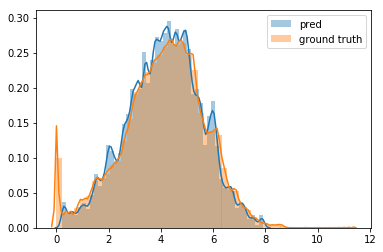

In [59]:
# For meter 0
valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=0, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

target_meter 1 (4182440, 35)
cat_features [32, 33, 34]
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.09577	valid_1's l2: 2.38945
[40]	training's l2: 1.70256	valid_1's l2: 1.85751
[60]	training's l2: 1.58151	valid_1's l2: 1.75794
[80]	training's l2: 1.49211	valid_1's l2: 1.72241
[100]	training's l2: 1.43537	valid_1's l2: 1.70788
[120]	training's l2: 1.3929	valid_1's l2: 1.7013
[140]	training's l2: 1.35925	valid_1's l2: 1.7006
[160]	training's l2: 1.3299	valid_1's l2: 1.6961
Early stopping, best iteration is:
[153]	training's l2: 1.3424	valid_1's l2: 1.69499
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.3423993878655334}, 'valid_1': {'l2': 1.6949929488968392}})
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.0604	valid_1's l2: 2.00887
[40]	training's l2: 1.67079	valid_1's l2: 1.77447
[60]	training's l2: 1.55414	valid_1'

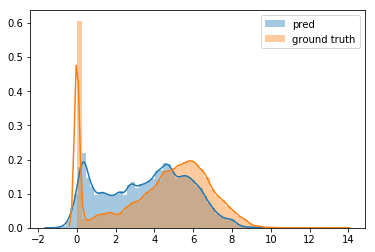

In [60]:
# For meter 1
valid_score, models1, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=1, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

target_meter 2 (2708713, 35)
cat_features [32, 33, 34]
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.22185	valid_1's l2: 2.88965
[40]	training's l2: 1.83206	valid_1's l2: 2.48185
[60]	training's l2: 1.72562	valid_1's l2: 2.44255
[80]	training's l2: 1.67278	valid_1's l2: 2.43121
[100]	training's l2: 1.63587	valid_1's l2: 2.4299
Early stopping, best iteration is:
[89]	training's l2: 1.65429	valid_1's l2: 2.4252
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.6542878464223962}, 'valid_1': {'l2': 2.4252025913743998}})
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.22221	valid_1's l2: 2.54715
[40]	training's l2: 1.81841	valid_1's l2: 2.34324
[60]	training's l2: 1.71866	valid_1's l2: 2.27349
[80]	training's l2: 1.66125	valid_1's l2: 2.248
[100]	training's l2: 1.62495	valid_1's l2: 2.24596
Early stopping, best iteration is:
[

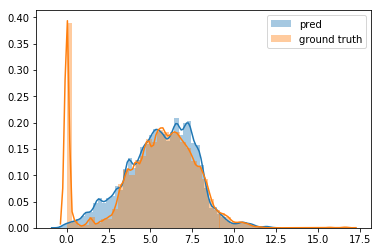

In [61]:
# For meter 2
valid_score, models2, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=2, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

target_meter 3 (1264037, 35)
cat_features [32, 33, 34]
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.35953	valid_1's l2: 3.16944
[40]	training's l2: 2.04023	valid_1's l2: 2.5309
[60]	training's l2: 1.93306	valid_1's l2: 2.41902
[80]	training's l2: 1.87643	valid_1's l2: 2.38293
[100]	training's l2: 1.83286	valid_1's l2: 2.34892
[120]	training's l2: 1.7959	valid_1's l2: 2.33116
[140]	training's l2: 1.76562	valid_1's l2: 2.30993
[160]	training's l2: 1.7413	valid_1's l2: 2.30192
Early stopping, best iteration is:
[158]	training's l2: 1.74321	valid_1's l2: 2.30057
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.7432149528142145}, 'valid_1': {'l2': 2.300573655017985}})
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.2697	valid_1's l2: 2.72504
[40]	training's l2: 1.92129	valid_1's l2: 2.64275
[60]	training's l2: 1.82891	valid_

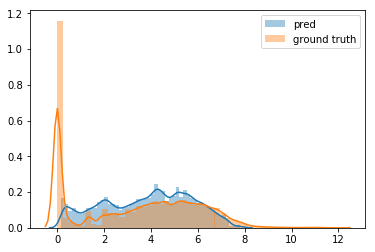

In [62]:
# For meter 3
valid_score, models3, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, target_meter=3, return_info=True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='ground truth')
plt.legend()
plt.show()

del y_pred_valid, y_train

In [63]:
try:
    del train_df
    del train_df_original
    del weather_train_df
except:
    pass
gc.collect()

7915

## Create test data

In [64]:
print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)

print('preprocessing weather...')
weather_test_df = timestamp_align(weather_test_df)
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
weather_test_df = weather_test_df[['site_id', 'timestamp'] + weather_cols]
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...


/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 1908.76 MB
Memory usage after optimization is: 874.88 MB
Decreased by 54.2%
Memory usage of dataframe is 19.83 MB
Memory usage after optimization is: 16.13 MB
Decreased by 18.7%


0

In [65]:
del df_2d
del site_ids_offsets
gc.collect()

0

In [66]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left', copy=False)
    target_test_df = pd.merge(target_test_df, building_stats_df, on=['building_id', 'meter'], how='left', copy=False)
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left', copy=False)
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [67]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

del X_test
gc.collect()

iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 11min 52s, sys: 1min 30s, total: 13min 22s
Wall time: 4min 48s


291

In [68]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()
y_test1 = pred(X_test, models1)

del X_test
gc.collect()

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 8min 3s, sys: 32.1 s, total: 8min 35s
Wall time: 2min 41s


99

In [69]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()
y_test2 = pred(X_test, models2)

del X_test
gc.collect()

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 3min 20s, sys: 18.9 s, total: 3min 39s
Wall time: 1min 15s


60

In [70]:
%%time
X_test = create_X(test_df, target_meter=3)
gc.collect()
y_test3 = pred(X_test, models3)

del X_test
gc.collect()

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 2min 40s, sys: 8.35 s, total: 2min 48s
Wall time: 52 s


33

Text(0.5, 1.0, 'test prediction for meter type 0')

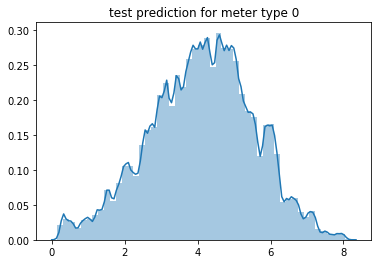

In [71]:
sns.distplot(y_test0)
plt.title('test prediction for meter type 0')

Text(0.5, 1.0, 'test prediction for meter type 1')

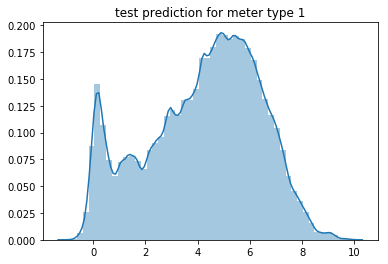

In [72]:
sns.distplot(y_test1)
plt.title('test prediction for meter type 1')

Text(0.5, 1.0, 'test prediction for meter type 2')

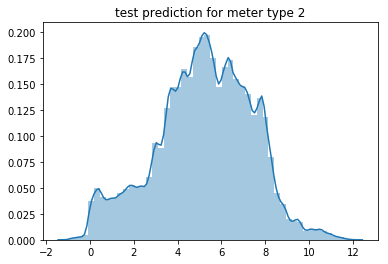

In [73]:
sns.distplot(y_test2)
plt.title('test prediction for meter type 2')

Text(0.5, 1.0, 'test prediction for meter type 3')

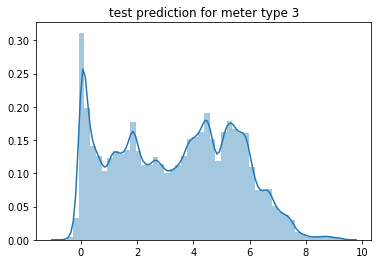

In [74]:
sns.distplot(y_test3)
plt.title('test prediction for meter type 3')

In [75]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [76]:
print(np.sum(y_test0 < 0))
print(np.sum(y_test1 < 0))
print(np.sum(y_test2 < 0))
print(np.sum(y_test3 < 0))

y_test0 = np.where(y_test0 < 0, 0, y_test0)
y_test1 = np.where(y_test1 < 0, 0, y_test1)
y_test2 = np.where(y_test2 < 0, 0, y_test2)
y_test3 = np.where(y_test3 < 0, 0, y_test3)

0
183914
30956
58630


In [77]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [78]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [79]:
sample_submission.head()

,row_id,meter_reading
0,0,192.947227
1,1,94.664449
2,2,12.541636
3,3,327.642175
4,4,1324.046394


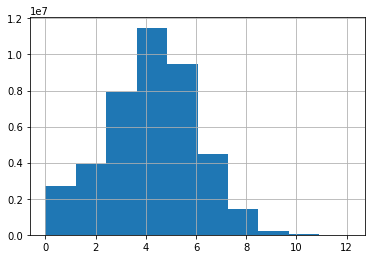

In [80]:
np.log1p(sample_submission['meter_reading']).hist()

In [81]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

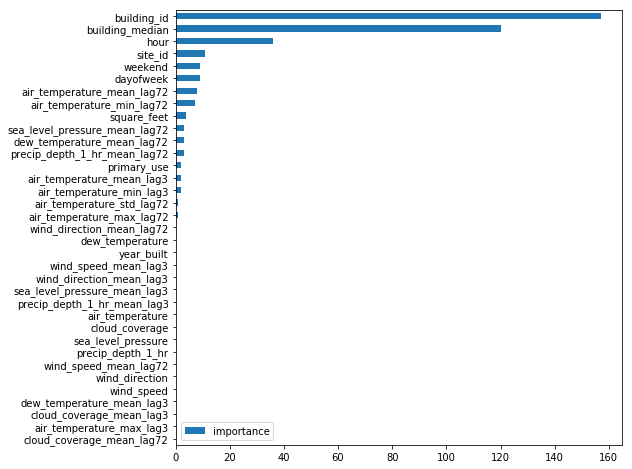

In [82]:
plot_feature_importance(models0[1])

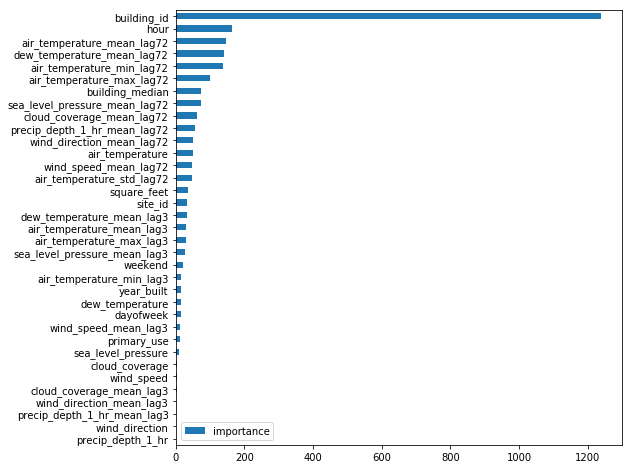

In [83]:
plot_feature_importance(models1[1])

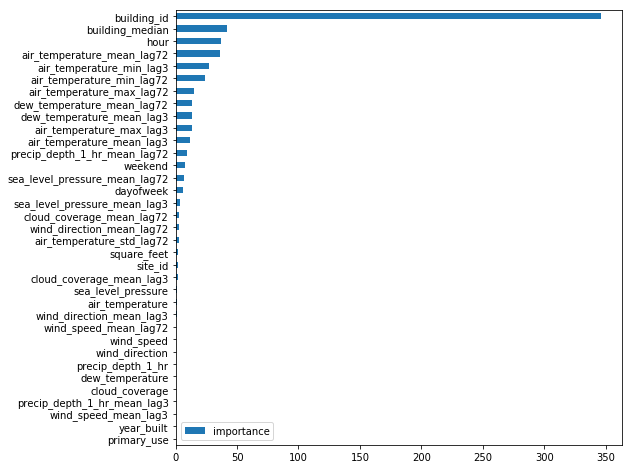

In [84]:
plot_feature_importance(models2[1])

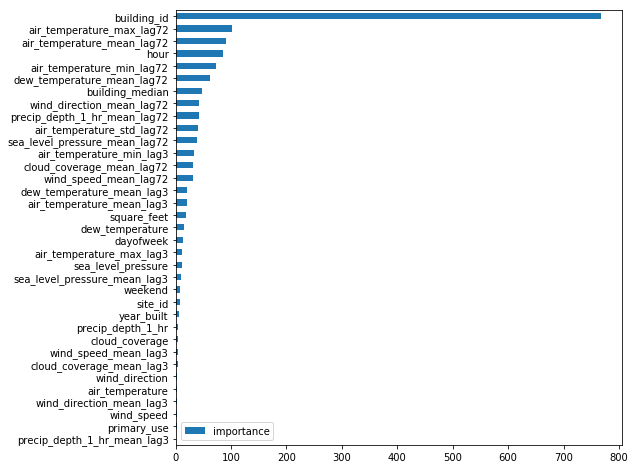

In [85]:
plot_feature_importance(models3[1])

<a id="id10"></a>
# More to go

## Other features...

That's all for this tutorial. However `optuna` further provides other useful functionality.

 - Store trial information in Relational Database (SQLite, PostgreSQL, MySQL) rather than on memory, to save hyperparameter search history.
 - Parallel distributed optimization: you can run several process at the same time to asyncronously search hyperparameters with many CPUs in parallel.

See Official document, github for details!

 - [web site](https://optuna.org/)
 - [github: pfnet/optuna](https://github.com/pfnet/optuna)
 - [document](https://optuna.readthedocs.io/en/latest/)


<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!</h3>